In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import json
import os

In [1]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/llama-3-8b-Instruct-bnb-4bit",
    dtype=None,        # None for auto detect
    load_in_4bit=True,
) # about 6GB in size

/workspace/dpo/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/dpo/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


==((====))==  Unsloth: Fast Llama patching release 2024.4
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.0+cu121. CUDA = 8.6. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.24. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
load_data_length =50
feature_num = 4
ignore_cache = True
# ignore_cache = False

In [9]:
import json
from pathlib import Path

folder = Path("coauthor")

def load_coauthor_raw(length=-1):
    data = []

    for i, file in enumerate(folder.glob("*.jsonl")):
        if length != -1 and i >= length:
            break
        text = file.read_text().splitlines()
        article = [json.loads(line) for line in text]
        data.append(article)
    return data

def apply_ops(doc, mask, ops, source):
    new_doc = ''
    new_mask = ''

    for i, op in enumerate(ops):
        if 'retain' in op:
            num_char = op['retain']
            new_doc += doc[:num_char]
            new_mask += mask[:num_char]
            doc = doc[num_char:]
            mask = mask[num_char:]

        elif 'insert' in op:
            text = op['insert']
            if isinstance(text, dict):
                if 'image' in text:
                    print('Skipping invalid object insertion (image)')
                else:
                    print('Ignore invalid insertions:', op)
                continue

            new_doc += text
            if source == 'api':
                new_mask += 'A' * len(text)
            else:
                new_mask += 'U' * len(text)

        elif 'delete' in op:
            num_char = op['delete']

            if doc:
                doc = doc[num_char:]
                mask = mask[num_char:]
            else:
                new_doc = new_doc[:-num_char]
                new_mask = new_mask[:-num_char]

        else:
            print('Ignore invalid operation:', op)

    return new_doc + doc, new_mask + mask


def extract_text_and_mask(events):
    prompt = events[0]['currentDoc'].strip()
    text = prompt
    mask = 'P' * len(prompt)

    for event in events:
        if 'ops' not in event['textDelta']:
            continue
        ops = event['textDelta']['ops']
        source = event['eventSource']
        text, mask = apply_ops(text, mask, ops, source)

    return text, mask

In [10]:
embed = model.model._modules['embed_tokens']._parameters['weight']
# convert to bit32
embed = embed.to(torch.float32)

In [41]:
import torch.nn.functional as F

def format_prompt(text):
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": 'Write an article for me.'},
        {"role": "assistant", "content": text},
    ]
    prompt =  tokenizer.apply_chat_template(
        messages,
        tokenize=False,
    )

    return prompt

def get_tokens_and_masks(text, mask, max_size, format=True):
    if format:
        text = format_prompt(text)
    output = tokenizer(text, return_tensors="pt", return_offsets_mapping=True, max_length=max_size, truncation=True)
    input_ids = output.input_ids
    offset_mapping = output.offset_mapping.detach().cpu().numpy()

    token_masks = []
    for offset in offset_mapping[0]:
        start, end = offset
        length = end - start

        if length == 0:
            token_masks.append(0.0)
            continue

        token_mask = mask[start:end]
        ai_percentage = token_mask.count('A') / length
        token_masks.append(ai_percentage)
    token_masks = np.array(token_masks)

    input_ids = input_ids.to(model.device)

    with torch.no_grad():
        output = model(input_ids, return_dict=True)

    print(input_ids.shape)
    print(output.logits.shape)

    input_ids = input_ids[0][1:]
    logits = output.logits[0]
    probs = torch.softmax(logits, dim=-1, dtype=torch.float32)
    eps = 1e-10
    probs = torch.clamp(probs, eps, 1)[:-1]
    bits = -torch.log2(probs)

    indices = torch.arange(0, input_ids.size(0)).to(model.device)
    token_bits = bits[indices, input_ids].detach().cpu().numpy()

    features = np.stack([token_bits], axis=-1)

    return features, token_masks[1:]

t, m = get_tokens_and_masks(a, b, 512)

torch.Size([1, 430])
torch.Size([1, 430, 128256])


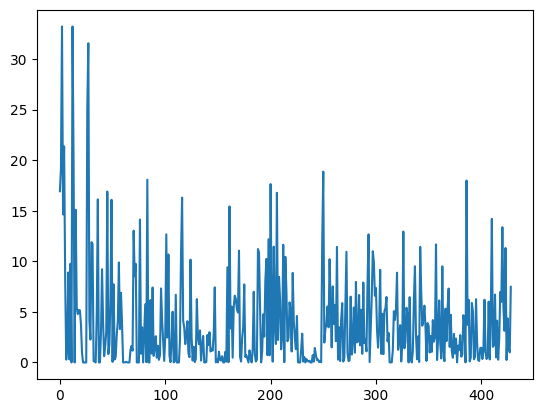

In [38]:
import matplotlib.pyplot as plt

plt.plot(t[:, 0])

In [24]:
from tqdm import tqdm

def process_data(data, max_size=1200):
    data_size = len(data)

    features = np.zeros((data_size, max_size, feature_num))
    labels = np.zeros((data_size, max_size, 1))
    masks = np.zeros((data_size, max_size, 1))

    for i, (text, mask) in tqdm(enumerate(data), total=data_size):
        # bit, mask, entropy, similarity = get_tokens_and_masks(text, mask)
        print(text, mask, max_size)
        feature, label = get_tokens_and_masks(text, mask, max_size)
        size = feature.shape[0]

        features[i, :size] = feature
        labels[i, :size, 0] = label
        masks[i, :size, 0] = 1

    return features, labels, masks

In [14]:
name = "Llama-3-8b-Instruct-bnb-4bit"

In [16]:
if not os.path.exists(f'cache/{name}'):
    os.mkdir(f'cache/{name}')

In [18]:
def store(features, labels, masks, data_name):
    data = np.concatenate([features, labels, masks], axis=-1)
    np.save(f'cache/{name}/{data_name}.npy', data)


def load(data_name):
    data = np.load(f'cache/{name}/{data_name}.npy')
    features = data[:, :, :-2]
    labels = data[:, :, -2:-1]
    masks = data[:, :, -1:]
    print(features.shape)
    print(labels.shape)
    print(masks.shape)

    return features, labels, masks


def exists(data_name):
    return Path(f'cache/{name}/{data_name}.npy').exists()

In [19]:
if exists('coatuhor') and not ignore_cache:
    cf, cl, cm = load('coatuhor')

else:
    coauthor_raw = load_coauthor_raw(load_data_length * 2)
    coauthor_data = list(map(extract_text_and_mask, coauthor_raw))

    cf, cl, cm = process_data(coauthor_data)
    store(cf, cl, cm, 'coatuhor')

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (429) must match the size of tensor b (428) at non-singleton dimension 0

In [ ]:
if exists('human') and not ignore_cache:
    hf, hl, hm = load('human')
else:
    with open("dataset_creation/human_dataset.json", "r") as f:
        human_data = json.load(f)
        human_data = list(map(lambda x: x["article"], human_data))

    human_data = human_data[:int(load_data_length * 1.5)]
    human_data = list(map(lambda x: (x, "U" * len(x)), human_data))

    hf, hl, hm = process_data(human_data)
    store(hf, hl, hm, 'human')

In [ ]:
if exists('generation') and not ignore_cache:
    gf, gl, gm = load('generation')
else:
    with open("dataset_creation/generation_dataset.json", "r") as f:
        generation_data = json.load(f)
        generation_data = list(map(lambda x: x["article"], generation_data))

    generation_data = generation_data[:load_data_length]
    generation_data = list(map(lambda x: (x, "A" * len(x)), generation_data))

    gf, gl, gm = process_data(generation_data)
    store(gf, gl, gm, 'generation')

In [ ]:
if exists('refinement') and not ignore_cache:
    rf, rl, rm = load('refinement')
else:
    with open("dataset_creation/refinement_dataset.json", "r") as f:
        refinement_data = json.load(f)
        refinement_data = list(map(lambda x: x["article"], refinement_data))

    refinement_data = refinement_data[:int(load_data_length)]
    refinement_data = list(map(lambda x: (x, "A" * len(x)), refinement_data))

    rf, rl, rm = process_data(refinement_data)
    store(rf, rl, rm, 'refinement')

In [ ]:
def create_mask(human_mask_length, total_length):
    return "U" * human_mask_length + "A" * (total_length - human_mask_length)

def preprocess(data):
    return data['article'], create_mask(data['mask'], len(data['article']))

if exists('completion') and not ignore_cache:
    cpf, cpl, cpm = load('completion')
else:
    with open("dataset_creation/completion_dataset.json", "r") as f:
        completion_data = json.load(f)
        completion_data = list(map(preprocess, completion_data))

    completion_data = completion_data[:int(load_data_length * 1.5)]
    cpf, cpl, cpm = process_data(completion_data)
    store(cpf, cpl, cpm, 'completion')

In [ ]:
# gf = gf[:10]
# gl = gl[:10]
# gm = gm[:10]

In [ ]:
features = np.concatenate([cf, hf, gf, cpf])
labels = np.concatenate([cl, hl, gl, cpl])
masks = np.concatenate([cm, hm, gm, cpm])

In [ ]:
def convolve_with_padding_same_size(signal, kernel):
    kernel_size = len(kernel)
    padded_signal = np.pad(signal, pad_width=(kernel_size//2, kernel_size//2), mode='reflect')
    convolved = np.convolve(padded_signal, kernel, mode='same')
    if kernel_size % 2 == 0:
        convolved = convolved[kernel_size//2:-kernel_size//2]
    else:
        convolved = convolved[kernel_size//2:-(kernel_size//2)-1]

    return convolved

def avg_pool(data, kernel_size):
    new_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        chunk = data[max(0, i-kernel_size//2):i+kernel_size//2]
        new_data[i] = np.mean(chunk)
    return new_data

def smooth_1d(data, mask, kernel):
    data = data[mask == 1]
    data = convolve_with_padding_same_size(data, kernel)
    # data = avg_pool(data, kernel.shape[0])
    return data

def smooth(data, mask, kernel):
    new_data = np.zeros_like(data)
    # print(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            smoothed_data = smooth_1d(data[i, :, j], mask[i, :, 0], kernel)
            new_data[i, :smoothed_data.shape[0], j] = smoothed_data
    return new_data

In [ ]:
# factor = 200

# f = smooth(cf, cm, np.ones(factor) / factor)

# i = 15

# plot1 = cf[i, :, 0][cm[i, :, 0] == 1]
# plot2 = f[i, :, 0][cm[i, :, 0] == 1]

# plt.plot(plot1)
# plt.plot(plot2)
# plt.show()

In [ ]:
import numpy as np

def boxcar_kernel(length):
    return np.ones(length) / length

def boxcar_left_kernel(length):
    kernel = np.ones(length) / length
    if length % 2 == 0:
        kernel[length // 2:] = 0
    else:
        kernel[length // 2 + 1:] = 0
    return kernel

def boxcar_right_kernel(length):
    kernel = np.ones(length) / length
    kernel[:length // 2] = 0
    return kernel

def gaussian_kernel(length, sigma=1):
    x = np.linspace(-length // 2, length // 2, length)
    return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def triangular_kernel(length):
    return (1 - np.abs(np.linspace(-1, 1, length)))

def epanechnikov_kernel(length):
    x = np.linspace(-1, 1, length)
    return np.where(np.abs(x) <= 1, 0.75 * (1 - x**2), 0)

def hamming_kernel(length):
    return np.hamming(length)

def hanning_kernel(length):
    return np.hanning(length)

def blackman_kernel(length):
    return np.blackman(length)

def kaiser_kernel(length, beta=0.5):
    return np.kaiser(length, beta)

def cosine_kernel(length):
    return np.cos(np.linspace(-np.pi/2, np.pi/2, length))

def sinc_kernel(length):
    x = np.linspace(-length // 2, length // 2, length)
    return np.where(x == 0, 1, np.sin(x) / x)

def bartlett_kernel(length):
    return np.bartlett(length)

def welch_kernel(length):
    n = np.arange(0, length)
    return 1 - ((n - (length - 1) / 2) / ((length - 1) / 2))**2

def normalize(kernel):
    return kernel / np.sum(kernel)

kernels = {
    'boxcar': boxcar_kernel,
    'boxcar_left': boxcar_left_kernel,
    'boxcar_right': boxcar_right_kernel,
    'gaussian': gaussian_kernel,
    'triangular': triangular_kernel,
    'epanechnikov': epanechnikov_kernel,
    'hamming': hamming_kernel,
    'hanning': hanning_kernel,
    'blackman': blackman_kernel,
    'kaiser': kaiser_kernel,
    'cosine': cosine_kernel,
    'sinc': sinc_kernel,
    'bartlett': bartlett_kernel,
    'welch': welch_kernel,
    'welch': welch_kernel,
}

In [ ]:
# # simple 3d plot with plotly
# import plotly.graph_objects as go

# #entropy, similarity, bits, stdev
# def display_3d(features, labels, masks, kernel, display_size, smooth_label=False):
#     f = smooth(features, masks, kernel)
#     f = f[masks[:, :, 0] == 1]

#     if smooth_label:
#         l = smooth(labels, masks, kernel)[masks == 1]
#     else:
#         l = labels[masks == 1]

#     if display_size > f.shape[0]:
#         display_size = f.shape[0]
#     indices = np.random.choice(f.shape[0], display_size, replace=False)
#     f = f[indices]
#     l = l[indices]

#     x = f[:, 3]
#     y = f[:, 1]
#     z = f[:, 2]

#     go.Figure(data=[go.Scatter3d(
#         x=x,
#         y=y,
#         z=z,
#         mode='markers',
#         marker=dict(
#             size=1,
#             color=l,                # set color to an array/list of desired values
#             colorscale='Viridis',   # choose a colorscale
#             opacity=0.8
#         ),
#     )]).show()


# kernel_size = 20
# kernel = kernels['triangular'](kernel_size)

# display_3d(features, labels, masks, kernel, 100000, smooth_label=True)

In [ ]:
def get_data(features, masks, labels, smooth_kernel, data_size=10000, indices=None):
    smooth_kernel = normalize(smooth_kernel)
    smooth_features = smooth(features, masks, smooth_kernel)

    X = smooth_features[masks[:, :, 0] == 1]
    Y = labels[masks == 1]

    if data_size > X.shape[0]:
        data_size = X.shape[0]
    # randomly select from the data
    if indices is None:
        indices = np.random.choice(X.shape[0], data_size, replace=False)
    X = X[indices]
    Y = Y[indices]

    Y = Y > 0.5

    return X, Y, indices

In [ ]:
X, Y, _ = get_data(features, masks, labels, kernels['boxcar'](20), data_size=1000000)

entropy = X[:, 0]
similarity = X[:, 1]
bits = X[:, 2]
stdev = X[:, 3]

ai_count = entropy[Y == 1].shape[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].scatter(entropy[Y == 0][:ai_count], bits[Y == 0]
                [:ai_count], s=0.1, alpha=0.03)
axes[1].scatter(entropy[Y == 1], bits[Y == 1], s=0.1, alpha=0.03)

for ax in axes:
    ax.plot((0, 10), (0, 10), c='r')
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Bits')

axes[0].set_title('Human')
axes[1].set_title('AI')

plt.show()

In [ ]:
embed.shape

In [ ]:
embed_matrix = embed.detach().cpu().numpy()

In [ ]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embed_matrix)

embed_pca = pca.transform(embed_matrix)
plt.scatter(embed_pca[:, 0], embed_pca[:, 1], s=0.1)

In [ ]:
embed_matrix.shape

In [ ]:
import re

raw_vocabs = tokenizer.get_vocab()

vocab = [''] * len(raw_vocabs)

en_indicies = []

for key, value in raw_vocabs.items():
    vocab[value] = key
    if re.match(r'^[a-zA-Z]+$', key):
        en_indicies.append(value)

In [ ]:
len(en_indicies) / len(vocab)

In [ ]:
from umap import UMAP
import plotly.graph_objects as go
reduce = UMAP(n_components=3)

en_indicies = np.array(en_indicies)
en_embed_matrix = embed_matrix[en_indicies]

embed_umap = reduce.fit_transform(en_embed_matrix)

hover_data = [str(vocab[i]) for i in en_indicies]

print(len(hover_data))
print(embed_umap.shape)

fig = go.Figure(data=[go.Scatter3d(
    x=embed_umap[:, 0],
    y=embed_umap[:, 1],
    z=embed_umap[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=np.arange(len(hover_data)),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8,
        colorbar=dict(
            title="Vocab"
        )
    ),
    hovertext=hover_data
)])

fig.show()

In [ ]:
def metrics(pred, true):
    accuracy = np.mean(pred == true)
    precision = np.sum(pred & true) / np.sum(pred)
    recall = np.sum(pred & true) / np.sum(true)
    f1 = 2 * precision * recall / (precision + recall)
    return accuracy, precision, recall, f1

#test metrics
pred = np.array([True, False, True, False, True, False, True, False, True, False])
true = np.array([True, False, False, False, True, False, True, False, True, False])

metrics(pred, true)

In [ ]:
# from collections import defaultdict
# from sklearn.svm import SVC
# from tqdm import tqdm

# smooth_factors = [
#     15, 20, 30, 45, 70, 100, 200, 350, 550, 700, 1000, 1200
# ]

# sigma = [
#     1, 2, 4, 8, 16, 32, 64, 128, 256
# ]

# beta = [
#     0.25, 0.5, 1, 2, 4, 8, 16, 32, 64
# ]

# kernel_strategies = {
#     'boxcar': boxcar_kernel,
#     'boxcar_left': boxcar_left_kernel,
#     'boxcar_right': boxcar_right_kernel,
#     'gaussian': gaussian_kernel,
#     'triangular': triangular_kernel,
#     'epanechnikov': epanechnikov_kernel,
#     'hamming': hamming_kernel,
#     'hanning': hanning_kernel,
#     'blackman': blackman_kernel,
#     'kaiser': kaiser_kernel,
#     'cosine': cosine_kernel,
#     'bartlett': bartlett_kernel,
# }

# svr_correctnesses = defaultdict(list)

# train_size = 5000
# test_size = 10000

# features = np.concatenate([cf, hf, gf, rf])
# labels = np.concatenate([cl, hl, gl, rl])
# masks = np.concatenate([cm, hm, gm, rm])


# for kernel_name, kernel in tqdm(kernel_strategies.items()):
#     for smooth_factor in smooth_factors:
#             svm_type = 'rbf'
#             kernel_args = [None]
#             if kernel_name == 'gaussian':
#                 kernel_args = sigma
#             if kernel_name == 'kaiser':
#                 kernel_args = beta

#             for arg in kernel_args:
#                 if arg == None:
#                     smooth_kernel = normalize(kernel(smooth_factor))
#                     name = kernel_name
#                 else:
#                     smooth_kernel = normalize(kernel(smooth_factor, arg))
#                     name = f'{kernel_name}_{arg}'

#                 X_train, Y_train = get_data(features, masks, labels, smooth_kernel=smooth_kernel, data_size=train_size)
#                 X_test, Y_test = get_data(features, masks, labels, smooth_kernel=smooth_kernel, data_size=test_size)

#                 svr = SVC(kernel=svm_type)
#                 svr.fit(X_train, Y_train)

#                 X_pred = svr.predict(X_test)
#                 correctness = metrics(X_pred, Y_test)

#                 svr_correctnesses[name].append(correctness)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC

kernel = kernels['triangular'](27)

train_size = 10000
test_size = 10000

X_train, Y_train, indicies = get_data(features, masks, labels, smooth_kernel=kernel, data_size=train_size)
X_test, Y_test, _ = get_data(features, masks, labels, smooth_kernel=kernel, data_size=test_size, indices=indicies)

svr = SVC(kernel='rbf', probability=True, C=1)

svr.fit(X_train, Y_train)

Y_probs = svr.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot(fpr, thresholds, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot(tpr, thresholds, color='darkblue', lw=2, label='Thresholds')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve')
plt.show()

In [ ]:
youden = tpr - fpr
youden_max = np.argmax(youden)

plt.plot(thresholds, youden)

print(thresholds[youden_max])

tests = [
    (cf, cl, cm, 'coauthor'),
    (hf, hl, hm, 'human'),
    (gf, gl, gm, 'generation'),
    # (rf, rl, rm, 'refinement'),
    (cpf, cpl, cpm, 'completion'),
    (features, labels, masks, 'all'),
]
results = {}

train_size = 5000
test_size = 5000

for feature, label, mask, name in tests:
    X_train, Y_train, indices = get_data(feature, mask, label, smooth_kernel=kernel, data_size=train_size)
    X_test, Y_test, _ = get_data(feature, mask, label, smooth_kernel=kernel, data_size=test_size, indices=indices)

    Y_probs = svr.predict_proba(X_test)[:, 1]
    Y_pred = Y_probs > thresholds[youden_max]

    print(np.mean(Y_pred))
    correctness = metrics(Y_pred, Y_test)
    results[name] = correctness

for key, item in results.items():
    print(key, item)

In [ ]:
def num_to_color(score):
    return f"hsl({(1 - score) * 120}, 100%, 50%)"

def write_color(text, num):
    return f"<span style='color: {num_to_color(num)};'>{text}</span>"

def save_as_markdown(essay, offset_mapping, predictions, f):
    for i in range(len(offset_mapping)):
        start = offset_mapping[i][0]
        end = offset_mapping[i][1]

        # Writing the colored part using inline HTML within Markdown
        p = predictions[i]

        colored_text = write_color(essay[start:end], p)
        f.write(colored_text)

        # Writing the non-colored part between this and the next segment
        if i < len(offset_mapping) - 1:
            f.write(essay[end:offset_mapping[i+1][0]])
        else:
            f.write(essay[end:])

def save_as_markdown_pre_mask(essay, mask, f):
    for i in range(len(mask)):
        if mask[i] == 'A':
            colored_text = write_color(essay[i], 1)
        else:
            colored_text = write_color(essay[i], 0)
        f.write(colored_text)

def save_comparsion_as_markdown(essay, offset_mapping, actual, predictions, file_name):
    with open(file_name, "w") as f:
        f.write("# Actual\n")
        save_as_markdown_pre_mask(essay, actual, f)
        f.write("\n\n# Predicted\n")
        save_as_markdown(essay, offset_mapping, predictions, f)

In [ ]:
def save_comparsion_data(data, index, name):
    text, label = data[index]
    feature, _, mask = process_data([data[index]])
    feature = smooth(feature, masks, kernel)[0]
    Y_probs = svr.predict_proba(features)[:, 1]
    Y_pred = Y_probs > thresholds[youden_max]
    # Y_probs = (Y_probs - 0.23) / (0.4) + 0.5
    # Y_probs = np.clip(Y_probs, 0, 1)
    offset_mapping = tokenizer(text, return_offsets_mapping=True, max_length=1200, truncation=True).offset_mapping
    save_comparsion_as_markdown(text, offset_mapping, label, Y_pred, f"{name}_{index}.md")

In [ ]:
index = 5

coauthor_raw = load_coauthor_raw(10)
coauthor_data = list(map(extract_text_and_mask, coauthor_raw))

save_comparsion_data(coauthor_data, index, "coauthor")

In [ ]:
with open("dataset_creation/human_dataset.json", "r") as f:
    generation_data = json.load(f)
    generation_data = list(map(lambda x: x["article"], generation_data))

generation_data = generation_data[:load_data_length]
generation_data = list(map(lambda x: (x, "H" * len(x)), generation_data))

index = 23

save_comparsion_data(generation_data, index, "generation")

In [ ]:
with open(f'{path}.txt', 'r') as f:
    text = f.read()
features, _, masks = process_data([(text, "A" * len(text))])

features = smooth(features, masks, kernel)[0]
Y_probs = svr.predict_proba(features)[:, 1]
# print(Y_probs)
Y_pred = Y_probs > thresholds[youden_max]

# Y_probs = (Y_probs - 0.23) / (0.4) + 0.5
# Y_probs = np.clip(Y_probs, 0, 1)

offset_mapping = tokenizer(text, return_offsets_mapping=True, max_length=1200, truncation=True).offset_mapping
save_as_markdown(text, offset_mapping, Y_probs, f'{path}_pred')

In [ ]:
# #export model
# from joblib import dump

# dump(svr, 'model.joblib')

In [ ]:


labels = np.concatenate([cl, hl, gl, rl, cpl])
masks = np.concatenate([cm, hm, gm, rm, cpm])
features = np.concatenate([cf, hf, gf, rf, cpf])

smooth_features = smooth(features, masks, kernel)
smooth_features = smooth_features[masks[:, :, 0] == 1]

labels = labels[masks == 1]
labels = labels > 0.5

indicies = np.random.choice(smooth_features.shape[0], 30000, replace=False)
smooth_features = smooth_features[indicies]
labels = labels[indicies]

#convert to 0 and 1
labels = labels.astype(int)

In [ ]:
# plot

fig, ax = plt.subplots(3, 2, figsize=(10, 15))

names = ['entropy', 'similarity', 'bits', 'stdev']
combinations = [
    (0, 1), (0, 2), (0, 3),
    (1, 2), (1, 3),
    (2, 3)
]

for i, (x, y) in enumerate(combinations):
    ax[i // 2, i % 2].scatter(smooth_features[:, x], smooth_features[:, y], c=labels, s=0.3)
    ax[i // 2, i % 2].set_xlabel(names[x])
    ax[i // 2, i % 2].set_ylabel(names[y])


In [ ]:
# Assuming smooth_factors and svr_correctnesses are defined somewhere in your code
# Example:
# smooth_factors = np.linspace(0, 1, 100)
# svr_correctnesses = {'model1': [[acc1, prec1, rec1, f11], ...], 'model2': [...], ...}

fig, axes = plt.subplots(5, 6, figsize=(30, 30))

# Define a color map for the four metrics
colors = ['blue', 'green', 'red', 'black']  # for example, accuracy, precision, recall, f1

for i, (name, correctnesses) in enumerate(svr_correctnesses.items()):
    row = i // 6
    col = i % 6
    ax = axes[row, col]
    ax.set_title(name)

    correctnesses = np.array(correctnesses)

    accuracy = correctnesses[:, 0]
    precision = correctnesses[:, 1]
    recall = correctnesses[:, 2]
    f1 = correctnesses[:, 3]

    # Use the colors defined above for each metric
    ax.plot(smooth_factors, accuracy, label='accuracy', color=colors[0])
    ax.plot(smooth_factors, precision, label='precision', color=colors[1])
    ax.plot(smooth_factors, recall, label='recall', color=colors[2])
    ax.plot(smooth_factors, f1, label='f1', color=colors[3])

    ax.set_ylim(0.65, 1.0)
    # log scale for x axis
    ax.set_xscale('log')

    ax.set_xlabel('kernel size')
    ax.set_ylabel('scores')

# Set the labels for the first subplot only to avoid cluttering, they are the same for all anyway
axes[0, 0].legend()
# add gloabl titl
# add some space between subplots
fig.tight_layout()
plt.show()